# Capstone Project - Automatic Ticket Classsification - Using NLP

## By Madhu Nuthula
### Student at Institute of Data 2022-2023
### Graduate Certificate in Data Science and AI
### Presented on 20/01/2023


# Problem Statement
Cluster the complaints in to 5 categories.

Create a model that can classify the tickets automatically which will help route the complaint to appropriate department and resolve it faster.


# About Dataset
The Dataset is sourced from Kaggle, which  contains the complaints record of a financial institution from The Consumer Financial Protection Bureau (CFPB) a federal U.S. agency that acts as a mediator when disputes arise between financial institutions and consumers. Via a web form, consumers can send the agency a narrative of their dispute. 
Extracted required information from the JSON file.

Initial extracted dataset was in shape(78313 rows, 5 columns)

### Columns:
Complaints 	-	Actual complaint text

Product		-	Complaint Category chosen by customer

Sub_product	-	Complaint sub-category chosen by customer

Issue		- 	Issue about the complaint written by customer

Sub_issue	-	Sub issue about the complaint written by customer


In [3]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import spacy
from spacy.tokenizer import Tokenizer
import en_core_web_md


from sklearn.model_selection import train_test_split
import re
from spacy import displacy
import string
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = r"C:\Users\Raveena's PC\Documents\Data_Science\DATA_Files\Automatic-Ticket-Classification-Dataset\complaints-2021-05-14_08_16.json"

In [5]:
response = json.load(open(path))

In [6]:
len(response)

78313

### Identity and extract useful information from json file

In [7]:
response[3]

{'_index': 'complaint-public-v2',
 '_type': 'complaint',
 '_id': '2673060',
 '_score': 0.0,
 '_source': {'tags': None,
  'zip_code': '48066',
  'complaint_id': '2673060',
  'issue': 'Trouble during payment process',
  'date_received': '2017-09-13T12:00:00-05:00',
  'state': 'MI',
  'consumer_disputed': 'N/A',
  'product': 'Mortgage',
  'company_response': 'Closed with explanation',
  'company': 'JPMORGAN CHASE & CO.',
  'submitted_via': 'Web',
  'date_sent_to_company': '2017-09-14T12:00:00-05:00',
  'company_public_response': None,
  'sub_product': 'Conventional home mortgage',
  'timely': 'Yes',
  'complaint_what_happened': '',
  'sub_issue': None,
  'consumer_consent_provided': 'Consent not provided'}}

In [8]:
response[1]["_source"]["product"]

'Debt collection'

In [9]:
response[1]["_source"]["sub_product"]

'Credit card debt'

In [10]:
response[1]["_source"]["sub_issue"]

"Didn't receive enough information to verify debt"

In [11]:
response[1]["_source"]["issue"]

'Written notification about debt'

In [12]:
response[1]["_source"]["complaint_what_happened"]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [13]:
# Extract Complaints in to a list
complaints_list = []
for i in range(78313):
    a = response[i]["_source"]["complaint_what_happened"]
    complaints_list.append(a)

In [14]:
len(complaints_list)

78313

In [15]:
# Extract other texts in to a 4 different list
product_list = []
for i in range(78313):
    b = response[i]["_source"]["product"]
    product_list.append(b)

    
# # Extract in to a list
sub_product_list = []
for i in range(78313):
    a = response[i]["_source"]["sub_product"]
    sub_product_list.append(a)

    
# Extract in to a list
sub_issue_list = []
for i in range(78313):
    a = response[i]["_source"]["sub_issue"]
    sub_issue_list.append(a)
    
    
# Extract in to a list
issue_list = []
for i in range(78313):
    a = response[i]["_source"]["issue"]
    issue_list.append(a)

In [16]:
len(product_list), len(sub_product_list), len(sub_issue_list), len(issue_list)

(78313, 78313, 78313, 78313)

In [17]:
# Creating a Data Frame using the lists created

df = pd.DataFrame(data = (list(zip(complaints_list, product_list, sub_product_list, sub_issue_list, issue_list))), columns = ["complaints", "product", "sub_product", "sub_issue", "issue"])

In [18]:
df.shape

(78313, 5)

In [19]:
df.head()

,complaints,product,sub_product,sub_issue,issue
0,,Debt collection,Credit card debt,Debt is not yours,Attempts to collect debt not owed
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt,Didn't receive enough information to verify debt,Written notification about debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card,Problem with rewards from credit card,"Other features, terms, or problems"
3,,Mortgage,Conventional home mortgage,None,Trouble during payment process
4,,Credit card or prepaid card,General-purpose credit card or charge card,Charged too much interest,Fees or interest


In [20]:
df.tail()

,complaints,product,sub_product,sub_issue,issue
78308,,Checking or savings account,Checking account,Funds not received from closed account,Closing an account
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card,Other problem,"Other features, terms, or problems"
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account,Transaction was not authorized,Problem with a lender or other company chargin...
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card,Problem with balance transfer,"Other features, terms, or problems"
78312,Roughly 10+ years ago I closed out my accounts...,Payday loan,None,None,Payment to acct not credited


In [21]:
# using "space" to replace any missing values in the df
df = df.replace(np.nan, " ")

In [22]:
df["complaints"] = df["complaints"].replace("", " ")

In [23]:
# unique Value counts for product
Category_count = df["product"].value_counts()
Category_count

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

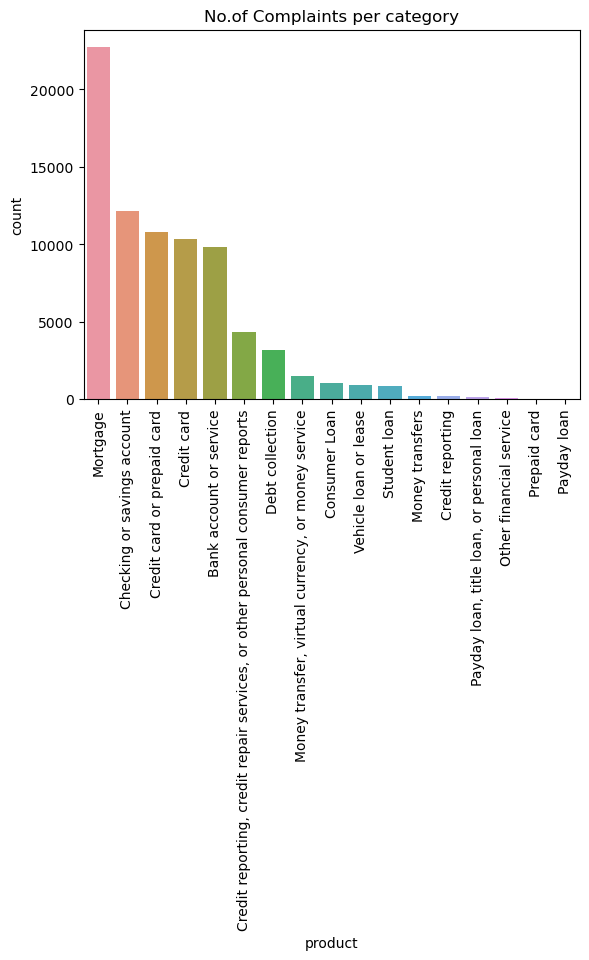

In [24]:
# countplot categories
sns.countplot(x = "product", data = df, order = Category_count.index).set_title("No.of Complaints per category")
plt.xticks(rotation=90);

In [271]:
# unique Value counts for sub_product
sub_Category_count = df["sub_product"].value_counts()
sub_Category_count

Checking account                              17182
                                              10571
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: sub_product, Length: 73, dtype: int64

In [293]:
# unique Value counts for issue
issue_count = df["issue"].value_counts()
issue_count

Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Name: issue, Length: 154, dtype:

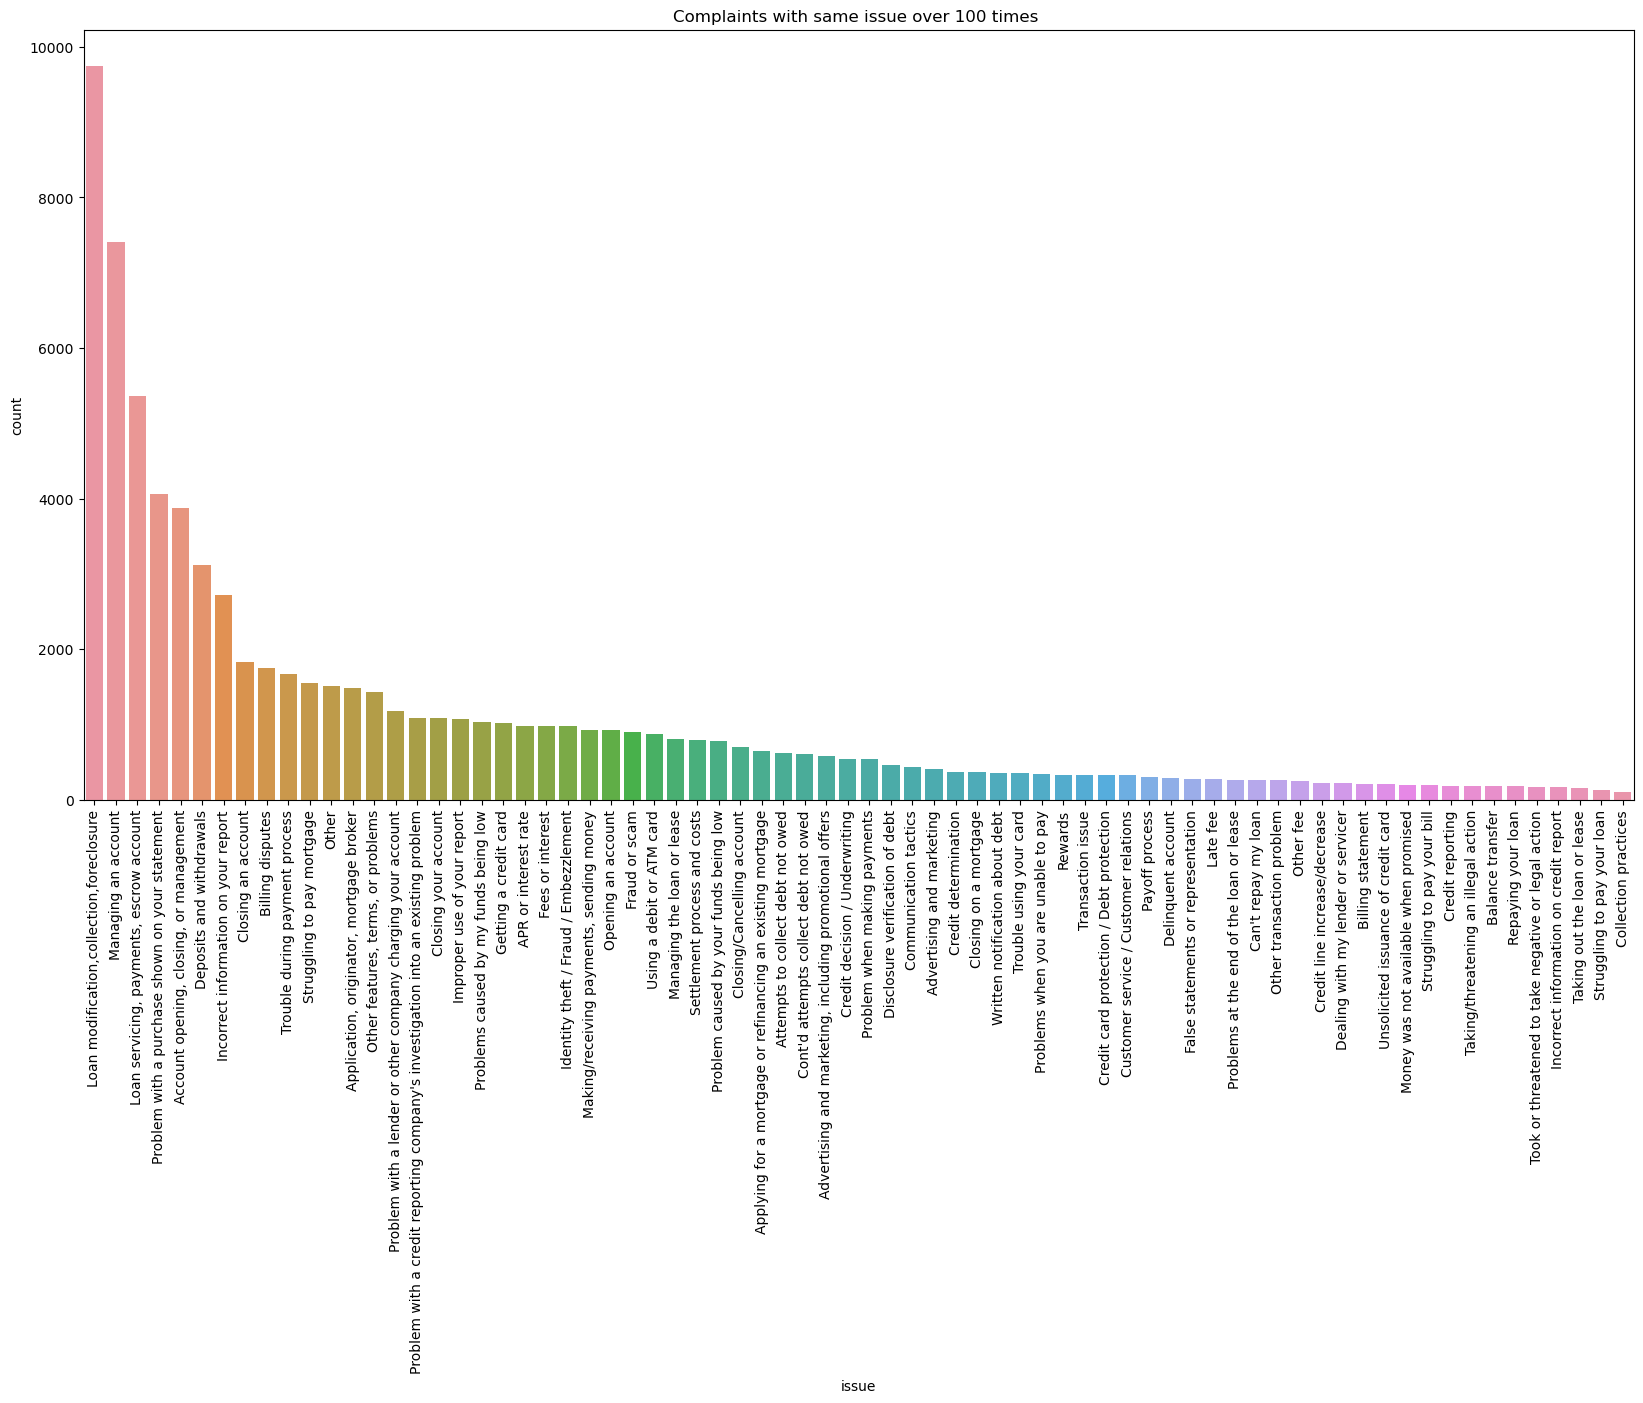

In [303]:
# countplot categories
plt.figure(figsize = (20,10))
sns.countplot(x = "issue", data = df, order = issue_count[issue_count>100].index).set_title("Complaints with same issue over 100 times ")
plt.xticks(rotation=90);

In [329]:
# unique Value counts for issue
sub_issue_count = df["sub_issue"].value_counts()
len(sub_issue_count)

206

In [330]:
# New column"category" by combing product and sub_products
df["category"] = df["product"]+ ", " +df["sub_product"]

In [331]:
#adding all other useful text to complaints
df["complaints"] = df["complaints"]+ ", " +df["sub_issue"]+ ", " +df["issue"]

In [332]:
df.head(10)

,complaints,product,sub_product,sub_issue,issue,category
0,", Debt is not yours, Attempts to collect debt...",Debt collection,Credit card debt,Debt is not yours,Attempts to collect debt not owed,"Debt collection, Credit card debt"
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt,Didn't receive enough information to verify debt,Written notification about debt,"Debt collection, Credit card debt"
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card,Problem with rewards from credit card,"Other features, terms, or problems","Credit card or prepaid card, General-purpose c..."
3,", , Trouble during payment process",Mortgage,Conventional home mortgage,,Trouble during payment process,"Mortgage, Conventional home mortgage"
4,", Charged too much interest, Fees or interest",Credit card or prepaid card,General-purpose credit card or charge card,Charged too much interest,Fees or interest,"Credit card or prepaid card, General-purpose c..."
5,", Problem using a debit or ATM card, Managing...",Checking or savings account,Checking account,Problem using a debit or ATM card,Managing an account,"Checking or savings account, Checking account"
6,", Problem using a debit or ATM card, Managing...",Checking or savings account,Checking account,Problem using a debit or ATM card,Managing an account,"Checking or savings account, Checking account"
7,", , Trouble during payment process",Mortgage,Conventional home mortgage,,Trouble during payment process,"Mortgage, Conventional home mortgage"
8,", Company closed your account, Closing an acc...",Checking or savings account,Checking account,Company closed your account,Closing an account,"Checking or savings account, Checking account"
9,", Cashing a check, Managing an account",Checking or savings account,Checking account,Cashing a check,Managing an account,"Checking or savings account, Checking account"


In [333]:
df = df.drop(columns = ["product", "sub_product", "sub_issue", "issue"])

In [334]:
df.head(10)

,complaints,category
0,", Debt is not yours, Attempts to collect debt...","Debt collection, Credit card debt"
1,Good morning my name is XXXX XXXX and I apprec...,"Debt collection, Credit card debt"
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"Credit card or prepaid card, General-purpose c..."
3,", , Trouble during payment process","Mortgage, Conventional home mortgage"
4,", Charged too much interest, Fees or interest","Credit card or prepaid card, General-purpose c..."
5,", Problem using a debit or ATM card, Managing...","Checking or savings account, Checking account"
6,", Problem using a debit or ATM card, Managing...","Checking or savings account, Checking account"
7,", , Trouble during payment process","Mortgage, Conventional home mortgage"
8,", Company closed your account, Closing an acc...","Checking or savings account, Checking account"
9,", Cashing a check, Managing an account","Checking or savings account, Checking account"


In [335]:
df.isnull().sum()

complaints    0
category      0
dtype: int64

# Using Spacy for Text Processing

In [469]:
nlp = spacy.load("en_core_web_md")

In [389]:
# Sentence Length
sent_len = []

for i in range(df.shape[0]):
    doc = nlp(df.complaints[i])
    count=0
    for sentence in doc.sents:
        count +=1
    sent_len.append(count)   

In [392]:
max(sent_len)

265

In [393]:
df["sentence_length"] = pd.Series(sent_len)

In [420]:
#complaint with Maximum sentences
pd.set_option("display.max_colwidth", None)
df[df["sentence_length"]==265]["complaints"]

14476    -- -- -- -- -- Forwarded message -- -- -- -- - From : XXXX XXXX XXXX Date : Wed, XX/XX/2019 at XXXX XXXX Subject : Fwd : Follow-up : XXXX XXXX Police Report Filing on Saturday XX/XX/2019 by XXXX XXXX Regarding Fraud To : XXXX Begin forwarded message XXXX From : XXXX XXXX XXXX Date : XX/XX/2019 at XXXX XXXX PDT To : XXXX Subject : Fwd : Follow-up : XXXX XXXX Police Report Filing on Saturday XX/XX/2019 by XXXX XXXX Regarding Fraud Hi there, I am writing to provide a written record of my experience with XXXX. I will not sign a hold harmless letter at this time as it is my understanding that XXXX is fully liable for enabling their client 's scam behavior. \n\nI am on a call with one of XXXX 's representatives now who has informed me that there is not a local email that I can sent my full report to, and thus I am emailing this email. \n\nAs a result, XXXX has on file a full record of what transpired and this can be referenced by XXXX representatives moving forward. \n\nPlease let m

In [460]:
%%time
#Word count
word_count = []

for i in range(df.shape[0]):
    count = len(df.complaints[i].split())
    word_count.append(count)
    

Wall time: 1.95 s


In [465]:
max(word_count)

5585

In [463]:
df["word_count"] = pd.Series(word_count)

In [466]:
#complaint with Maximum words
pd.set_option("display.max_colwidth", None)
df[df["word_count"]==5585]["complaints"]

31952    Alleged Account # XXXX FINAL RESPONSE TO JPMORGAN CHASE BANK NA CO MORTGAGE DEPT Reference number XXXX, XXXX : NOTICE - MOST IMPORTANT - The documents for this alleged Mortgage Assignment is nothing but forgeries and robo signing at best. NO ACTUAL FINDINGS - Within the request they the bank JPMorgan Chase NA Mortgage Co was requested to provide proof of said signatures that of the original signatures not forgeries. The signatures are proven not to be that of XXXX XXXX XXXX nor that of XXXX XXXX XXXX the real persons in flesh. Whom do not and has never given any permission to JPMorgan Chase, nor XXXX Mortgage XXXX XXXX XXXX XXXX Funding. WRONG IDENTITY - JPMorgan Chase Bank has referred to XXXX XXXX XXXX & XXXX XXXX XXXX as XXXX XXXX XXXX and XXXX XXXX XXXX, as well as XXXX XXXX or as in XXXX XXXX using the same address within this claim. This is completely and utterly identity theft, fraud no contract. There are no forms presented of an actual ledgers, copy of a check for pay

In [470]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x259240aadc0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x259240aa760>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x25923e2c350>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x2589970ab40>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x25884f14f80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x25923e2c430>)]

# Clean Text

In [485]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    text = re.sub(r"\s+", " ", text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    # remove <br />
    text = re.sub(r'(<br...|<.br...)', '', text)
    # remove urls 
    text = re.sub(r'(http|https)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', text)
    
    return text

In [486]:
%%time
df.complaints = df.complaints.apply(clean_text)

Wall time: 5.62 s


In [487]:
df.head()

,complaints,category,sentence_length,word_count
0,", Debt is not yours, Attempts to collect debt not owed","Debt collection, Credit card debt",1,11
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt","Debt collection, Credit card debt",7,103
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems","Credit card or prepaid card, General-purpose credit card or charge card",4,74
3,", , Trouble during payment process","Mortgage, Conventional home mortgage",1,6
4,", Charged too much interest, Fees or interest","Credit card or prepaid card, General-purpose credit card or charge card",1,8


#### Remove Stop Words, Punctuations and Lemmatize the text

In [488]:
def convert_text(text):

    words = nlp(text)
    data_clean = [w.lemma_.lower() for w in words if (not w.is_stop and not w.is_punct and not w.like_num)] 
    text = ' '.join(data_clean)
    
    return text

In [489]:
%%time
df.lemma_comp = df.complaints.apply(convert_text)

Wall time: 38min 40s


In [535]:
df.head()

,complaints,category,sentence_length,word_count,lemma_comp
0,", Debt is not yours, Attempts to collect debt not owed","Debt collection, Credit card debt",1,11,debt attempt collect debt owe
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt","Debt collection, Credit card debt",7,103,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems","Credit card or prepaid card, General-purpose credit card or charge card",4,74,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem
3,", , Trouble during payment process","Mortgage, Conventional home mortgage",1,6,trouble payment process
4,", Charged too much interest, Fees or interest","Credit card or prepaid card, General-purpose credit card or charge card",1,8,charge interest fee interest


In [498]:
df["lemma_comp"] = pd.Series(df.lemma_comp)

In [499]:
df.head()

,complaints,category,sentence_length,word_count,lemma_comp
0,", Debt is not yours, Attempts to collect debt not owed","Debt collection, Credit card debt",1,11,debt attempt collect debt owe
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt","Debt collection, Credit card debt",7,103,good morning xxxx xxxx appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help receive information verify debt write notification debt
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems","Credit card or prepaid card, General-purpose credit card or charge card",4,74,upgrade xxxx xxxx card xx xx/2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead problem reward credit card feature term problem
3,", , Trouble during payment process","Mortgage, Conventional home mortgage",1,6,trouble payment process
4,", Charged too much interest, Fees or interest","Credit card or prepaid card, General-purpose credit card or charge card",1,8,charge interest fee interest


In [502]:
#remove characters"x"
def clean_text(text):
    text = re.sub(r"x+", "", text)
    return text

In [504]:

df["lemma_comp"] = df["lemma_comp"].apply(clean_text)

In [505]:
df.head()

,complaints,category,sentence_length,word_count,lemma_comp
0,", Debt is not yours, Attempts to collect debt not owed","Debt collection, Credit card debt",1,11,debt attempt collect debt owe
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt","Debt collection, Credit card debt",7,103,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems","Credit card or prepaid card, General-purpose credit card or charge card",4,74,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem
3,", , Trouble during payment process","Mortgage, Conventional home mortgage",1,6,trouble payment process
4,", Charged too much interest, Fees or interest","Credit card or prepaid card, General-purpose credit card or charge card",1,8,charge interest fee interest


In [510]:
# Concat all the text to single string
comp_text = df["lemma_comp"].str.cat()

In [525]:
Comp_text_raw = df["complaints"].str.cat()

# word Cloud Visuals

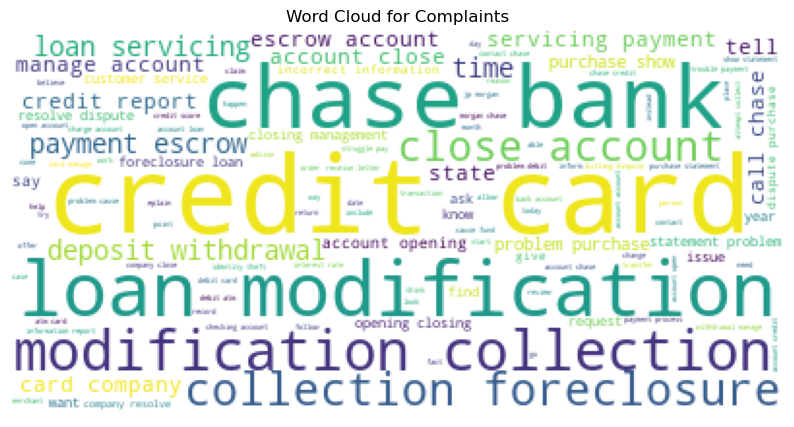

In [521]:
wordcloud = WordCloud(max_words=500, background_color = "white").generate(comp_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.title("Word Cloud for Complaints")
plt.axis("off")
plt.show()

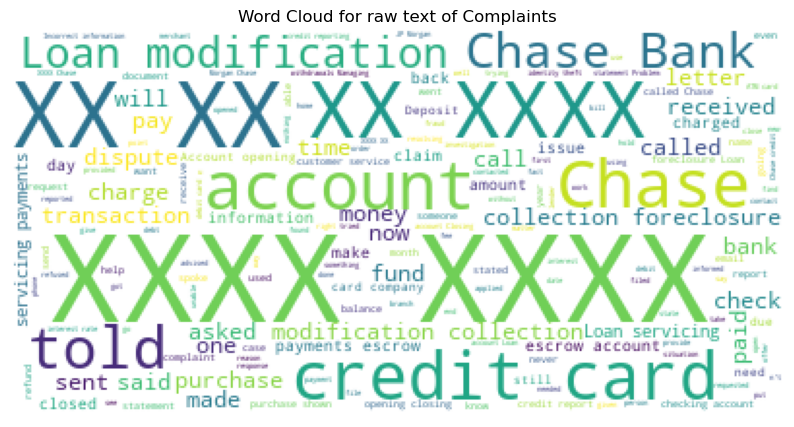

In [531]:
wordcloud_raw = WordCloud(max_words=500, background_color = "white").generate(Comp_text_raw)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_raw)
plt.title("Word Cloud for raw text of Complaints")
plt.axis("off")
plt.show()

In [534]:
from pathlib import Path  
filepath = Path(r"C:\Users\Raveena's PC\Documents\Data_Science\Capstone Project/out.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

In [538]:
# Add the Category Column and remove combined category
df["category"] = pd.Series(product_list)

In [539]:
df.head()

,complaints,category,sentence_length,word_count,lemma_comp
0,", Debt is not yours, Attempts to collect debt not owed",Debt collection,1,11,debt attempt collect debt owe
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt",Debt collection,7,103,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems",Credit card or prepaid card,4,74,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem
3,", , Trouble during payment process",Mortgage,1,6,trouble payment process
4,", Charged too much interest, Fees or interest",Credit card or prepaid card,1,8,charge interest fee interest


In [540]:
Category_count

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [542]:
#replace the categories as per above mentioned
df["category"] = df["category"].replace({"Mortgage":"Mortgage or Loans", "Consumer Loan":"Mortgage or Loans", "Vehicle loan or lease":"Mortgage or Loans", "Student loan":"Mortgage or Loans", "Payday loan, title loan, or personal loan":"Mortgage or Loans", "Payday loan":"Mortgage or Loans", 
                                         "Credit card or prepaid card":"Credit card or prepaid card", "Credit card":"Credit card or prepaid card", "Prepaid card":"Credit card or prepaid card", 
                                         "Checking or savings account":"Account Services", "Bank account or service":"Account Services",
                                         "Debt collection":"Debt COllection or credit reporting", "Credit reporting, credit repair services, or other personal consumer reports":"Debt COllection or credit reporting", "Credit reporting":"Debt COllection or credit reporting",  
                                         "Money transfer, virtual currency, or money service":"Other financial services", "Money transfers":"Other financial services", "Other financial service":"Other financial services"})

In [543]:
df.head()

,complaints,category,sentence_length,word_count,lemma_comp
0,", Debt is not yours, Attempts to collect debt not owed",Debt COllection or credit reporting,1,11,debt attempt collect debt owe
1,"Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help., Didn't receive enough information to verify debt, Written notification about debt",Debt COllection or credit reporting,7,103,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt
2,"I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me., Problem with rewards from credit card, Other features, terms, or problems",Credit card or prepaid card,4,74,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem
3,", , Trouble during payment process",Mortgage or Loans,1,6,trouble payment process
4,", Charged too much interest, Fees or interest",Credit card or prepaid card,1,8,charge interest fee interest


In [549]:
df1 = df[["lemma_comp", "sentence_length", "word_count", "category"]]

In [550]:
df1["category"].value_counts()

Mortgage or Loans                      25657
Account Services                       21963
Credit card or prepaid card            21202
Debt COllection or credit reporting     7703
Other financial services                1788
Name: category, dtype: int64

In [551]:
df1.head()

,lemma_comp,sentence_length,word_count,category
0,debt attempt collect debt owe,1,11,Debt COllection or credit reporting
1,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt,7,103,Debt COllection or credit reporting
2,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem,4,74,Credit card or prepaid card
3,trouble payment process,1,6,Mortgage or Loans
4,charge interest fee interest,1,8,Credit card or prepaid card


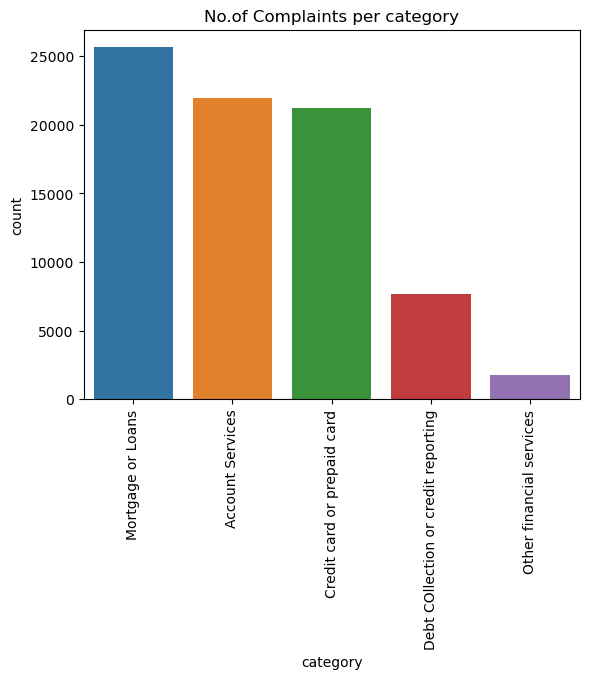

In [553]:
#visualise category count
sns.countplot(x = "category", data = df1, order = df1["category"].value_counts().index).set_title("No.of Complaints per category")
plt.xticks(rotation=90);

## Word clouds for each category

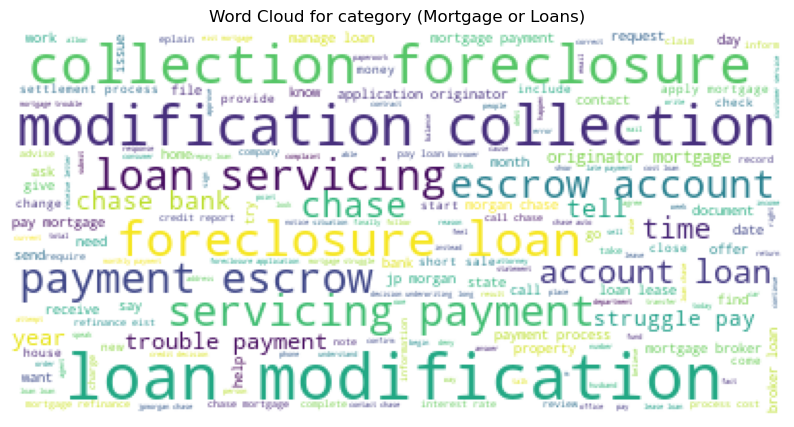

In [568]:
#WordCould for category "Mortgage or Loans"
Mortgage_text = df1[df1["category"]=="Mortgage or Loans"]["lemma_comp"].str.cat()

wordcloud_m = WordCloud(max_words=500, background_color = "white").generate(Mortgage_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_m)
plt.title("Word Cloud for category (Mortgage or Loans)")
plt.axis("off")
plt.show()


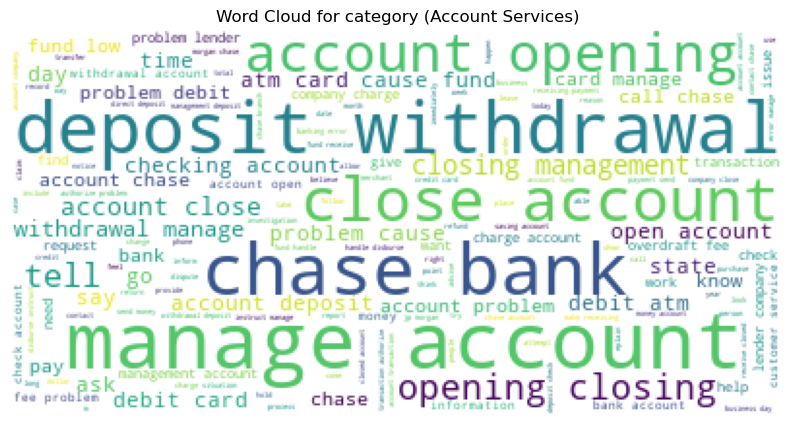

In [570]:
#WordCould for category "Account Services"
Account_Services_text = df1[df1["category"]=="Account Services"]["lemma_comp"].str.cat()

wordcloud_as = WordCloud(max_words=500, background_color = "white").generate(Account_Services_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_as)
plt.title("Word Cloud for category (Account Services)")
plt.axis("off")
plt.show()

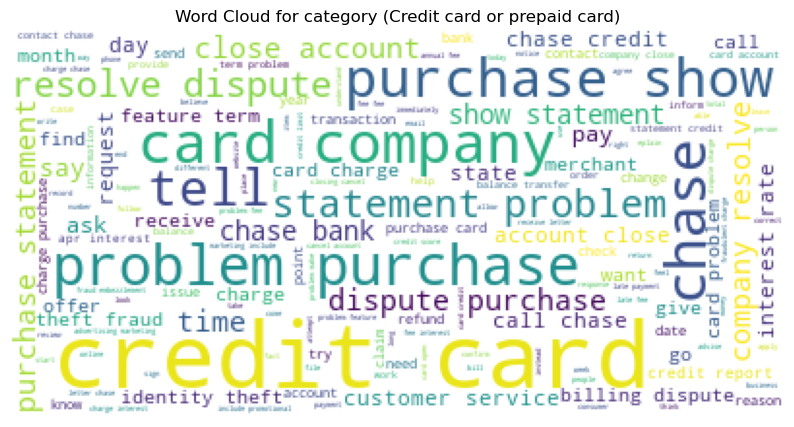

In [571]:
#WordCould for category "Credit card or prepaid card"
cc_pp_text = df1[df1["category"]=="Credit card or prepaid card"]["lemma_comp"].str.cat()

wordcloud_cc_pp = WordCloud(max_words=500, background_color = "white").generate(cc_pp_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_cc_pp)
plt.title("Word Cloud for category (Credit card or prepaid card)")
plt.axis("off")
plt.show()

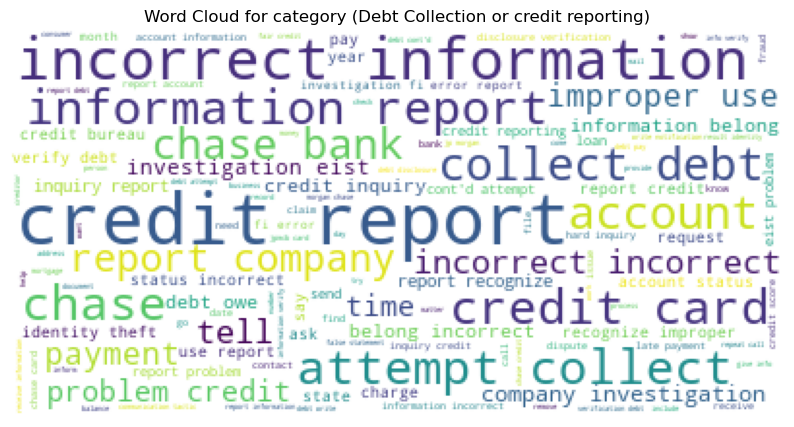

In [572]:
#WordCould for category "Debt COllection or credit reporting"
collection_text = df1[df1["category"]=="Debt COllection or credit reporting"]["lemma_comp"].str.cat()

wordcloud_col = WordCloud(max_words=500, background_color = "white").generate(collection_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_col)
plt.title("Word Cloud for category (Debt Collection or credit reporting)")
plt.axis("off")
plt.show()

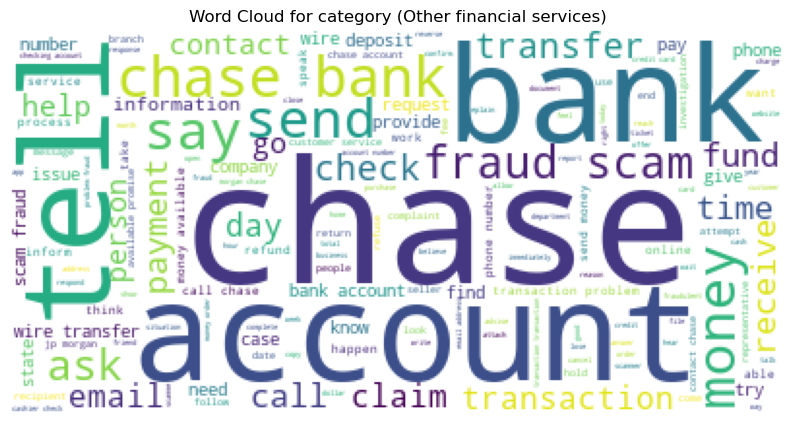

In [573]:
#WordCould for category "Other financial services"
financial_services_text = df1[df1["category"]=="Other financial services"]["lemma_comp"].str.cat()

wordcloud_fin = WordCloud(max_words=500, background_color = "white").generate(financial_services_text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_fin)
plt.title("Word Cloud for category (Other financial services)")
plt.axis("off")
plt.show()

In [576]:
# Assign numerical values to the categories
df1["category"] = df1["category"].replace({"Mortgage or Loans":1,
                                           "Credit card or prepaid card":2,
                                           "Account Services":3,
                                           "Debt COllection or credit reporting":4, 
                                           "Other financial services":5})
                                                               
                                        

In [577]:
df1["category"].value_counts()

1    25657
3    21963
2    21202
4     7703
5     1788
Name: category, dtype: int64

In [578]:
df1.head()

,lemma_comp,sentence_length,word_count,category
0,debt attempt collect debt owe,1,11,4
1,good morning appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account thank advance help receive information verify debt write notification debt,7,103,4
2,upgrade card /2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account change anniversary date consent recording agent mislead problem reward credit card feature term problem,4,74,2
3,trouble payment process,1,6,1
4,charge interest fee interest,1,8,2


In [580]:
# Save the final Data Frame to use for Modelling
filepath = Path(r"C:\Users\Raveena's PC\Documents\Data_Science\Capstone Project/df_modelling.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df1.to_csv(filepath) 

### Futher progress in two more notebooks 

### EDA2 - Capstone

### Modelling_Capstone_3